# CH7 AdaBoost

In [1]:
import numpy as np
import pandas as pd

- 集成方法(ensemble method), 元算法(meta-algorithm)
    - 不同算法的集成
    - 同一算法不同参数集成
    - 数据集不同部分分配给不同分类器之后集成
- 单层决策树，决策树桩，decision stump

## MLiA

### Multi Sampling

#### bagging

- 从原数据集中采样S次，生成S个新数据集
- 各分类器权重相等

#### boosting

- 各分类器权重不等，每个权重代表对应分类器上一轮迭代的成功度
- $\alpha_m=\frac{1}{2}log\frac{1-e_m}{e_m}$ 
- $e_m$为分类误差率$e_m=\sum_{i=1}^{N}P(G_m(x_i)\ne y_i)=\sum_{i=1}^{N}w_{mi}I(G_m(x_i)\ne y_i)$

### AdaBoost

#### Stump

In [2]:
def loadSimpData():
    dataMat = np.matrix([[1, 2.1],
                         [2, 1],
                         [1.3, 1],
                         [1, 1],
                         [2, 1]])
    classLabels = [1, 1, -1, -1, 1]
    return dataMat, classLabels

In [3]:
dataMat, classLabels = loadSimpData()

In [4]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == "lt":
        retArray[dataMatrix[:, dimen] <= threshVal] = -1
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1
    return retArray

In [5]:
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    # m samples, n features
    m,n = np.shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf 
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):
            for inequal in ['lt', 'gt']: 
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  
                print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" 
                      % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [6]:
D = np.mat(np.ones((5,1))/5)

In [7]:
buildStump(dataMat, classLabels, D)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineq

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

这里，对feature的遍历顺序会影响最后的输出结果

#### Boost

In [8]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        aggClassEst += alpha*classEst
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

In [9]:
classifierArr,aggClassEst = adaBoostTrainDS(dataMat,classLabels,9)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineq

#### Classify

In [10]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

In [11]:
adaClassify([[5,5],[0,0]],classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.24245332]
 [-1.24245332]]
[[ 2.04717228]
 [-2.04717228]]


matrix([[ 1.],
        [-1.]])

#### HorseColic

In [3]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split("\t"))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split("\t")
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [13]:
datArr, labelArr = loadDataSet("./Data/CH7/horseColicTraining2.txt")

In [14]:
classifierArray,aggClassEst = adaBoostTrainDS(datArr, labelArr, 40)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.405
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.595
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.562
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.438
split: dim 0, thresh 1.50, thresh ineq

split: dim 9, thresh 3.50, thresh ineqal: gt, the weighted error is 0.284
split: dim 9, thresh 4.00, thresh ineqal: lt, the weighted error is 0.656
split: dim 9, thresh 4.00, thresh ineqal: gt, the weighted error is 0.344
split: dim 9, thresh 4.50, thresh ineqal: lt, the weighted error is 0.656
split: dim 9, thresh 4.50, thresh ineqal: gt, the weighted error is 0.344
split: dim 9, thresh 5.00, thresh ineqal: lt, the weighted error is 0.595
split: dim 9, thresh 5.00, thresh ineqal: gt, the weighted error is 0.405
split: dim 10, thresh -0.40, thresh ineqal: lt, the weighted error is 0.405
split: dim 10, thresh -0.40, thresh ineqal: gt, the weighted error is 0.595
split: dim 10, thresh 0.00, thresh ineqal: lt, the weighted error is 0.405
split: dim 10, thresh 0.00, thresh ineqal: gt, the weighted error is 0.595
split: dim 10, thresh 0.40, thresh ineqal: lt, the weighted error is 0.405
split: dim 10, thresh 0.40, thresh ineqal: gt, the weighted error is 0.595
split: dim 10, thresh 0.80, th

split: dim 8, thresh 2.70, thresh ineqal: gt, the weighted error is 0.591
split: dim 8, thresh 3.00, thresh ineqal: lt, the weighted error is 0.407
split: dim 8, thresh 3.00, thresh ineqal: gt, the weighted error is 0.593
split: dim 9, thresh -0.50, thresh ineqal: lt, the weighted error is 0.593
split: dim 9, thresh -0.50, thresh ineqal: gt, the weighted error is 0.407
split: dim 9, thresh 0.00, thresh ineqal: lt, the weighted error is 0.504
split: dim 9, thresh 0.00, thresh ineqal: gt, the weighted error is 0.496
split: dim 9, thresh 0.50, thresh ineqal: lt, the weighted error is 0.504
split: dim 9, thresh 0.50, thresh ineqal: gt, the weighted error is 0.496
split: dim 9, thresh 1.00, thresh ineqal: lt, the weighted error is 0.541
split: dim 9, thresh 1.00, thresh ineqal: gt, the weighted error is 0.459
split: dim 9, thresh 1.50, thresh ineqal: lt, the weighted error is 0.541
split: dim 9, thresh 1.50, thresh ineqal: gt, the weighted error is 0.459
split: dim 9, thresh 2.00, thresh in

split: dim 8, thresh 2.70, thresh ineqal: gt, the weighted error is 0.550
split: dim 8, thresh 3.00, thresh ineqal: lt, the weighted error is 0.447
split: dim 8, thresh 3.00, thresh ineqal: gt, the weighted error is 0.553
split: dim 9, thresh -0.50, thresh ineqal: lt, the weighted error is 0.553
split: dim 9, thresh -0.50, thresh ineqal: gt, the weighted error is 0.447
split: dim 9, thresh 0.00, thresh ineqal: lt, the weighted error is 0.461
split: dim 9, thresh 0.00, thresh ineqal: gt, the weighted error is 0.539
split: dim 9, thresh 0.50, thresh ineqal: lt, the weighted error is 0.461
split: dim 9, thresh 0.50, thresh ineqal: gt, the weighted error is 0.539
split: dim 9, thresh 1.00, thresh ineqal: lt, the weighted error is 0.487
split: dim 9, thresh 1.00, thresh ineqal: gt, the weighted error is 0.513
split: dim 9, thresh 1.50, thresh ineqal: lt, the weighted error is 0.487
split: dim 9, thresh 1.50, thresh ineqal: gt, the weighted error is 0.513
split: dim 9, thresh 2.00, thresh in

split: dim 8, thresh -0.30, thresh ineqal: lt, the weighted error is 0.538
split: dim 8, thresh -0.30, thresh ineqal: gt, the weighted error is 0.462
split: dim 8, thresh 0.00, thresh ineqal: lt, the weighted error is 0.511
split: dim 8, thresh 0.00, thresh ineqal: gt, the weighted error is 0.489
split: dim 8, thresh 0.30, thresh ineqal: lt, the weighted error is 0.511
split: dim 8, thresh 0.30, thresh ineqal: gt, the weighted error is 0.489
split: dim 8, thresh 0.60, thresh ineqal: lt, the weighted error is 0.511
split: dim 8, thresh 0.60, thresh ineqal: gt, the weighted error is 0.489
split: dim 8, thresh 0.90, thresh ineqal: lt, the weighted error is 0.511
split: dim 8, thresh 0.90, thresh ineqal: gt, the weighted error is 0.489
split: dim 8, thresh 1.20, thresh ineqal: lt, the weighted error is 0.524
split: dim 8, thresh 1.20, thresh ineqal: gt, the weighted error is 0.476
split: dim 8, thresh 1.50, thresh ineqal: lt, the weighted error is 0.524
split: dim 8, thresh 1.50, thresh in

split: dim 4, thresh -9.60, thresh ineqal: lt, the weighted error is 0.543
split: dim 4, thresh -9.60, thresh ineqal: gt, the weighted error is 0.457
split: dim 4, thresh 0.00, thresh ineqal: lt, the weighted error is 0.501
split: dim 4, thresh 0.00, thresh ineqal: gt, the weighted error is 0.499
split: dim 4, thresh 9.60, thresh ineqal: lt, the weighted error is 0.505
split: dim 4, thresh 9.60, thresh ineqal: gt, the weighted error is 0.495
split: dim 4, thresh 19.20, thresh ineqal: lt, the weighted error is 0.531
split: dim 4, thresh 19.20, thresh ineqal: gt, the weighted error is 0.469
split: dim 4, thresh 28.80, thresh ineqal: lt, the weighted error is 0.438
split: dim 4, thresh 28.80, thresh ineqal: gt, the weighted error is 0.562
split: dim 4, thresh 38.40, thresh ineqal: lt, the weighted error is 0.451
split: dim 4, thresh 38.40, thresh ineqal: gt, the weighted error is 0.549
split: dim 4, thresh 48.00, thresh ineqal: lt, the weighted error is 0.447
split: dim 4, thresh 48.00, t

split: dim 2, thresh 36.72, thresh ineqal: lt, the weighted error is 0.466
split: dim 2, thresh 36.72, thresh ineqal: gt, the weighted error is 0.534
split: dim 2, thresh 40.80, thresh ineqal: lt, the weighted error is 0.488
split: dim 2, thresh 40.80, thresh ineqal: gt, the weighted error is 0.512
split: dim 3, thresh -18.40, thresh ineqal: lt, the weighted error is 0.512
split: dim 3, thresh -18.40, thresh ineqal: gt, the weighted error is 0.488
split: dim 3, thresh 0.00, thresh ineqal: lt, the weighted error is 0.486
split: dim 3, thresh 0.00, thresh ineqal: gt, the weighted error is 0.514
split: dim 3, thresh 18.40, thresh ineqal: lt, the weighted error is 0.486
split: dim 3, thresh 18.40, thresh ineqal: gt, the weighted error is 0.514
split: dim 3, thresh 36.80, thresh ineqal: lt, the weighted error is 0.464
split: dim 3, thresh 36.80, thresh ineqal: gt, the weighted error is 0.536
split: dim 3, thresh 55.20, thresh ineqal: lt, the weighted error is 0.496
split: dim 3, thresh 55.2

split: dim 6, thresh 0.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 6, thresh 0.40, thresh ineqal: lt, the weighted error is 0.488
split: dim 6, thresh 0.40, thresh ineqal: gt, the weighted error is 0.512
split: dim 6, thresh 0.80, thresh ineqal: lt, the weighted error is 0.488
split: dim 6, thresh 0.80, thresh ineqal: gt, the weighted error is 0.512
split: dim 6, thresh 1.20, thresh ineqal: lt, the weighted error is 0.533
split: dim 6, thresh 1.20, thresh ineqal: gt, the weighted error is 0.467
split: dim 6, thresh 1.60, thresh ineqal: lt, the weighted error is 0.533
split: dim 6, thresh 1.60, thresh ineqal: gt, the weighted error is 0.467
split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.521
split: dim 6, thresh 2.00, thresh ineqal: gt, the weighted error is 0.479
split: dim 6, thresh 2.40, thresh ineqal: lt, the weighted error is 0.521
split: dim 6, thresh 2.40, thresh ineqal: gt, the weighted error is 0.479
split: dim 6, thresh 2.80, thresh ineq

split: dim 2, thresh 12.24, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 12.24, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 16.32, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 16.32, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 20.40, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 20.40, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 24.48, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 24.48, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 28.56, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 28.56, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 32.64, thresh ineqal: lt, the weighted error is 0.484
split: dim 2, thresh 32.64, thresh ineqal: gt, the weighted error is 0.516
split: dim 2, thresh 36.72, thresh ineqal: lt, the weighted error is 0.466
split: dim 2, thresh 36.7

split: dim 11, thresh 3.20, thresh ineqal: lt, the weighted error is 0.477
split: dim 11, thresh 3.20, thresh ineqal: gt, the weighted error is 0.523
split: dim 11, thresh 3.60, thresh ineqal: lt, the weighted error is 0.477
split: dim 11, thresh 3.60, thresh ineqal: gt, the weighted error is 0.523
split: dim 11, thresh 4.00, thresh ineqal: lt, the weighted error is 0.500
split: dim 11, thresh 4.00, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh -0.30, thresh ineqal: lt, the weighted error is 0.500
split: dim 12, thresh -0.30, thresh ineqal: gt, the weighted error is 0.500
split: dim 12, thresh 0.00, thresh ineqal: lt, the weighted error is 0.497
split: dim 12, thresh 0.00, thresh ineqal: gt, the weighted error is 0.503
split: dim 12, thresh 0.30, thresh ineqal: lt, the weighted error is 0.497
split: dim 12, thresh 0.30, thresh ineqal: gt, the weighted error is 0.503
split: dim 12, thresh 0.60, thresh ineqal: lt, the weighted error is 0.497
split: dim 12, thresh 0

split: dim 4, thresh 48.00, thresh ineqal: lt, the weighted error is 0.468
split: dim 4, thresh 48.00, thresh ineqal: gt, the weighted error is 0.532
split: dim 4, thresh 57.60, thresh ineqal: lt, the weighted error is 0.462
split: dim 4, thresh 57.60, thresh ineqal: gt, the weighted error is 0.538
split: dim 4, thresh 67.20, thresh ineqal: lt, the weighted error is 0.479
split: dim 4, thresh 67.20, thresh ineqal: gt, the weighted error is 0.521
split: dim 4, thresh 76.80, thresh ineqal: lt, the weighted error is 0.472
split: dim 4, thresh 76.80, thresh ineqal: gt, the weighted error is 0.528
split: dim 4, thresh 86.40, thresh ineqal: lt, the weighted error is 0.468
split: dim 4, thresh 86.40, thresh ineqal: gt, the weighted error is 0.532
split: dim 4, thresh 96.00, thresh ineqal: lt, the weighted error is 0.472
split: dim 4, thresh 96.00, thresh ineqal: gt, the weighted error is 0.528
split: dim 5, thresh -0.40, thresh ineqal: lt, the weighted error is 0.528
split: dim 5, thresh -0.4

split: dim 6, thresh 0.00, thresh ineqal: gt, the weighted error is 0.507
split: dim 6, thresh 0.40, thresh ineqal: lt, the weighted error is 0.493
split: dim 6, thresh 0.40, thresh ineqal: gt, the weighted error is 0.507
split: dim 6, thresh 0.80, thresh ineqal: lt, the weighted error is 0.493
split: dim 6, thresh 0.80, thresh ineqal: gt, the weighted error is 0.507
split: dim 6, thresh 1.20, thresh ineqal: lt, the weighted error is 0.529
split: dim 6, thresh 1.20, thresh ineqal: gt, the weighted error is 0.471
split: dim 6, thresh 1.60, thresh ineqal: lt, the weighted error is 0.529
split: dim 6, thresh 1.60, thresh ineqal: gt, the weighted error is 0.471
split: dim 6, thresh 2.00, thresh ineqal: lt, the weighted error is 0.518
split: dim 6, thresh 2.00, thresh ineqal: gt, the weighted error is 0.482
split: dim 6, thresh 2.40, thresh ineqal: lt, the weighted error is 0.518
split: dim 6, thresh 2.40, thresh ineqal: gt, the weighted error is 0.482
split: dim 6, thresh 2.80, thresh ineq

split: dim 19, thresh 2.70, thresh ineqal: lt, the weighted error is 0.520
split: dim 19, thresh 2.70, thresh ineqal: gt, the weighted error is 0.480
split: dim 19, thresh 3.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 19, thresh 3.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 20, thresh -1.01, thresh ineqal: lt, the weighted error is 0.512
split: dim 20, thresh -1.01, thresh ineqal: gt, the weighted error is 0.488
split: dim 20, thresh 0.00, thresh ineqal: lt, the weighted error is 0.537
split: dim 20, thresh 0.00, thresh ineqal: gt, the weighted error is 0.463
split: dim 20, thresh 1.01, thresh ineqal: lt, the weighted error is 0.539
split: dim 20, thresh 1.01, thresh ineqal: gt, the weighted error is 0.461
split: dim 20, thresh 2.02, thresh ineqal: lt, the weighted error is 0.516
split: dim 20, thresh 2.02, thresh ineqal: gt, the weighted error is 0.484
split: dim 20, thresh 3.03, thresh ineqal: lt, the weighted error is 0.522
split: dim 20, thresh 3

split: dim 5, thresh 2.40, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 2.80, thresh ineqal: lt, the weighted error is 0.513
split: dim 5, thresh 2.80, thresh ineqal: gt, the weighted error is 0.487
split: dim 5, thresh 3.20, thresh ineqal: lt, the weighted error is 0.469
split: dim 5, thresh 3.20, thresh ineqal: gt, the weighted error is 0.531
split: dim 5, thresh 3.60, thresh ineqal: lt, the weighted error is 0.469
split: dim 5, thresh 3.60, thresh ineqal: gt, the weighted error is 0.531
split: dim 5, thresh 4.00, thresh ineqal: lt, the weighted error is 0.478
split: dim 5, thresh 4.00, thresh ineqal: gt, the weighted error is 0.522
split: dim 6, thresh -0.40, thresh ineqal: lt, the weighted error is 0.522
split: dim 6, thresh -0.40, thresh ineqal: gt, the weighted error is 0.478
split: dim 6, thresh 0.00, thresh ineqal: lt, the weighted error is 0.488
split: dim 6, thresh 0.00, thresh ineqal: gt, the weighted error is 0.512
split: dim 6, thresh 0.40, thresh in

split: dim 12, thresh 0.60, thresh ineqal: lt, the weighted error is 0.517
split: dim 12, thresh 0.60, thresh ineqal: gt, the weighted error is 0.483
split: dim 12, thresh 0.90, thresh ineqal: lt, the weighted error is 0.517
split: dim 12, thresh 0.90, thresh ineqal: gt, the weighted error is 0.483
split: dim 12, thresh 1.20, thresh ineqal: lt, the weighted error is 0.487
split: dim 12, thresh 1.20, thresh ineqal: gt, the weighted error is 0.513
split: dim 12, thresh 1.50, thresh ineqal: lt, the weighted error is 0.487
split: dim 12, thresh 1.50, thresh ineqal: gt, the weighted error is 0.513
split: dim 12, thresh 1.80, thresh ineqal: lt, the weighted error is 0.487
split: dim 12, thresh 1.80, thresh ineqal: gt, the weighted error is 0.513
split: dim 12, thresh 2.10, thresh ineqal: lt, the weighted error is 0.494
split: dim 12, thresh 2.10, thresh ineqal: gt, the weighted error is 0.506
split: dim 12, thresh 2.40, thresh ineqal: lt, the weighted error is 0.494
split: dim 12, thresh 2.4

split: dim 9, thresh -0.50, thresh ineqal: lt, the weighted error is 0.504
split: dim 9, thresh -0.50, thresh ineqal: gt, the weighted error is 0.496
split: dim 9, thresh 0.00, thresh ineqal: lt, the weighted error is 0.499
split: dim 9, thresh 0.00, thresh ineqal: gt, the weighted error is 0.501
split: dim 9, thresh 0.50, thresh ineqal: lt, the weighted error is 0.499
split: dim 9, thresh 0.50, thresh ineqal: gt, the weighted error is 0.501
split: dim 9, thresh 1.00, thresh ineqal: lt, the weighted error is 0.516
split: dim 9, thresh 1.00, thresh ineqal: gt, the weighted error is 0.484
split: dim 9, thresh 1.50, thresh ineqal: lt, the weighted error is 0.516
split: dim 9, thresh 1.50, thresh ineqal: gt, the weighted error is 0.484
split: dim 9, thresh 2.00, thresh ineqal: lt, the weighted error is 0.493
split: dim 9, thresh 2.00, thresh ineqal: gt, the weighted error is 0.507
split: dim 9, thresh 2.50, thresh ineqal: lt, the weighted error is 0.493
split: dim 9, thresh 2.50, thresh in

split: dim 19, thresh 1.50, thresh ineqal: lt, the weighted error is 0.507
split: dim 19, thresh 1.50, thresh ineqal: gt, the weighted error is 0.493
split: dim 19, thresh 1.80, thresh ineqal: lt, the weighted error is 0.507
split: dim 19, thresh 1.80, thresh ineqal: gt, the weighted error is 0.493
split: dim 19, thresh 2.10, thresh ineqal: lt, the weighted error is 0.494
split: dim 19, thresh 2.10, thresh ineqal: gt, the weighted error is 0.506
split: dim 19, thresh 2.40, thresh ineqal: lt, the weighted error is 0.494
split: dim 19, thresh 2.40, thresh ineqal: gt, the weighted error is 0.506
split: dim 19, thresh 2.70, thresh ineqal: lt, the weighted error is 0.494
split: dim 19, thresh 2.70, thresh ineqal: gt, the weighted error is 0.506
split: dim 19, thresh 3.00, thresh ineqal: lt, the weighted error is 0.476
split: dim 19, thresh 3.00, thresh ineqal: gt, the weighted error is 0.524
split: dim 20, thresh -1.01, thresh ineqal: lt, the weighted error is 0.524
split: dim 20, thresh -1

split: dim 7, thresh 3.60, thresh ineqal: gt, the weighted error is 0.464
split: dim 7, thresh 4.20, thresh ineqal: lt, the weighted error is 0.540
split: dim 7, thresh 4.20, thresh ineqal: gt, the weighted error is 0.460
split: dim 7, thresh 4.80, thresh ineqal: lt, the weighted error is 0.540
split: dim 7, thresh 4.80, thresh ineqal: gt, the weighted error is 0.460
split: dim 7, thresh 5.40, thresh ineqal: lt, the weighted error is 0.500
split: dim 7, thresh 5.40, thresh ineqal: gt, the weighted error is 0.500
split: dim 7, thresh 6.00, thresh ineqal: lt, the weighted error is 0.508
split: dim 7, thresh 6.00, thresh ineqal: gt, the weighted error is 0.492
split: dim 8, thresh -0.30, thresh ineqal: lt, the weighted error is 0.492
split: dim 8, thresh -0.30, thresh ineqal: gt, the weighted error is 0.508
split: dim 8, thresh 0.00, thresh ineqal: lt, the weighted error is 0.487
split: dim 8, thresh 0.00, thresh ineqal: gt, the weighted error is 0.513
split: dim 8, thresh 0.30, thresh in

split: dim 0, thresh 1.60, thresh ineqal: gt, the weighted error is 0.508
split: dim 0, thresh 1.70, thresh ineqal: lt, the weighted error is 0.492
split: dim 0, thresh 1.70, thresh ineqal: gt, the weighted error is 0.508
split: dim 0, thresh 1.80, thresh ineqal: lt, the weighted error is 0.492
split: dim 0, thresh 1.80, thresh ineqal: gt, the weighted error is 0.508
split: dim 0, thresh 1.90, thresh ineqal: lt, the weighted error is 0.492
split: dim 0, thresh 1.90, thresh ineqal: gt, the weighted error is 0.508
split: dim 0, thresh 2.00, thresh ineqal: lt, the weighted error is 0.489
split: dim 0, thresh 2.00, thresh ineqal: gt, the weighted error is 0.511
split: dim 1, thresh 0.20, thresh ineqal: lt, the weighted error is 0.511
split: dim 1, thresh 0.20, thresh ineqal: gt, the weighted error is 0.489
split: dim 1, thresh 1.00, thresh ineqal: lt, the weighted error is 0.518
split: dim 1, thresh 1.00, thresh ineqal: gt, the weighted error is 0.482
split: dim 1, thresh 1.80, thresh ineq

split: dim 20, thresh 5.05, thresh ineqal: lt, the weighted error is 0.492
split: dim 20, thresh 5.05, thresh ineqal: gt, the weighted error is 0.508
split: dim 20, thresh 6.06, thresh ineqal: lt, the weighted error is 0.490
split: dim 20, thresh 6.06, thresh ineqal: gt, the weighted error is 0.510
split: dim 20, thresh 7.07, thresh ineqal: lt, the weighted error is 0.495
split: dim 20, thresh 7.07, thresh ineqal: gt, the weighted error is 0.505
split: dim 20, thresh 8.08, thresh ineqal: lt, the weighted error is 0.491
split: dim 20, thresh 8.08, thresh ineqal: gt, the weighted error is 0.509
split: dim 20, thresh 9.09, thresh ineqal: lt, the weighted error is 0.491
split: dim 20, thresh 9.09, thresh ineqal: gt, the weighted error is 0.509
split: dim 20, thresh 10.10, thresh ineqal: lt, the weighted error is 0.486
split: dim 20, thresh 10.10, thresh ineqal: gt, the weighted error is 0.514
total error:  0.19063545150501673
split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error

In [15]:
testArr, testLabelArr = loadDataSet("./Data/CH7/horseColicTest2.txt")

In [16]:
prediction10 = adaClassify(testArr,classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

[[ 1.10638952]
 [ 1.23243505]
 [ 0.49576864]
 [-1.42276356]
 [ 0.24573552]
 [ 0.85558906]
 [ 0.11456246]
 [ 1.5769656 ]
 [ 1.1922666 ]
 [-0.97651869]
 [-0.14918333]
 [-0.24086573]
 [-0.60338502]
 [ 0.65442636]
 [ 0.13178882]
 [ 0.54324153]
 [ 0.9122138 ]
 [-1.06008395]
 [-0.65405701]
 [-0.69728539]
 [-0.65011192]
 [ 0.47334436]
 [-0.89371039]
 [-1.65816855]
 [ 2.32880936]
 [ 1.5641493 ]
 [ 1.88098106]
 [ 0.5218594 ]
 [ 1.8215193 ]
 [ 0.59664396]
 [ 2.14040267]
 [-0.95966037]
 [-0.99284796]
 [-0.24420538]
 [-0.93245795]
 [ 0.19457701]
 [ 1.24850303]
 [ 1.59316885]
 [ 1.36016751]
 [ 1.23350338]
 [ 0.94183485]
 [ 1.40475879]
 [ 0.25166445]
 [-1.27565476]
 [-0.83366346]
 [-0.0336757 ]
 [-0.88400792]
 [ 0.87212347]
 [ 0.57951008]
 [-0.62040605]
 [-0.88709689]
 [ 1.60216574]
 [ 1.448221  ]
 [ 1.14829857]
 [ 1.05585646]
 [ 1.11625807]
 [ 0.46364733]
 [-0.43272168]
 [ 0.95120425]
 [-1.49251099]
 [ 1.4496366 ]
 [-0.88709689]
 [ 0.03133898]
 [ 1.73150945]
 [ 1.17200673]
 [ 0.64181245]
 [ 0.34685

In [17]:
errArr = np.mat(np.ones((67,1)))
errArr[prediction10!=np.mat(testLabelArr).T].sum()/67

0.19402985074626866

In [18]:
classifierArray

[{'alpha': 0.4616623792657674, 'dim': 9, 'ineq': 'gt', 'thresh': 3.0},
 {'alpha': 0.31248245042467104, 'dim': 17, 'ineq': 'gt', 'thresh': 52.5},
 {'alpha': 0.28680973201695786,
  'dim': 3,
  'ineq': 'gt',
  'thresh': 55.199999999999996},
 {'alpha': 0.23297004638939492,
  'dim': 18,
  'ineq': 'lt',
  'thresh': 62.300000000000004},
 {'alpha': 0.19803846151213736, 'dim': 10, 'ineq': 'lt', 'thresh': 0.0},
 {'alpha': 0.18847887349020628, 'dim': 5, 'ineq': 'gt', 'thresh': 2.0},
 {'alpha': 0.1522736899747682, 'dim': 12, 'ineq': 'lt', 'thresh': 1.2},
 {'alpha': 0.15510870821690512, 'dim': 7, 'ineq': 'gt', 'thresh': 1.2},
 {'alpha': 0.1353619735335938, 'dim': 5, 'ineq': 'lt', 'thresh': 0.0},
 {'alpha': 0.12521587326132094,
  'dim': 4,
  'ineq': 'lt',
  'thresh': 28.799999999999997},
 {'alpha': 0.1334764812820768, 'dim': 11, 'ineq': 'gt', 'thresh': 2.0},
 {'alpha': 0.14182243253771037, 'dim': 9, 'ineq': 'lt', 'thresh': 4.0},
 {'alpha': 0.10264268449708046, 'dim': 14, 'ineq': 'gt', 'thresh': 0.0}

### Learning from Imbalanced Data

#### ROC AUC

分类性能度量指标

In [19]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print( "the Area Under the Curve is: ",ySum*xStep)


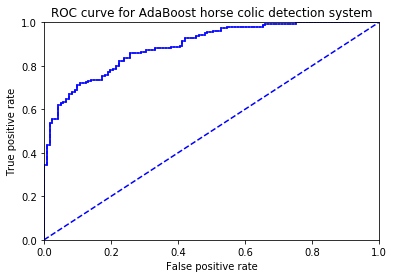

the Area Under the Curve is:  0.8918191104095092


In [20]:
plotROC(aggClassEst.T,labelArr)

#### Cost Sensitive Learning

- 代价矩阵
- 欠采样
- 过采样
- 欠采样 + 过采样

## Sklearn

### DT

In [64]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
clf = DecisionTreeClassifier()

In [79]:
X_train, y_train = loadDataSet("./Data/CH7/horseColicTraining2.txt")
clf.fit(X_train,y_train)
X_test, y_test = loadDataSet("./Data/CH7/horseColicTest2.txt")
y_pred = clf.predict(X_test)

In [80]:
print("Error rate : %1.2f %%" % (100*np.mean(y_pred!=y_test)))

Error rate : 32.84 %


### AdaBoostClassifier

[以下参考](http://scikit-learn.org/stable/modules/ensemble.html#ensemble)

AdaBoost can be used both for classification and regression problems:
- For multi-class classification, AdaBoostClassifier implements AdaBoost-SAMME and AdaBoost-SAMME.R [ZZRH2009].
- For regression, AdaBoostRegressor implements AdaBoost.R2 [D1997].


In [70]:
from sklearn.ensemble import AdaBoostClassifier

In [81]:
X_train, y_train = loadDataSet("./Data/CH7/horseColicTraining2.txt")

In [82]:
clf = AdaBoostClassifier(n_estimators=50)

In [83]:
clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [84]:
X_test, y_test = loadDataSet("./Data/CH7/horseColicTest2.txt")

In [85]:
y_pred = clf.predict(X_test)

In [86]:
import numpy as np
print("Error rate : %1.2f %%" % (100*np.mean(y_pred!=y_test)))

Error rate : 22.39 %
